In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import jax.numpy as jnp
import jax
from jax import random, jit

from tqdm.auto import tqdm
from sgmcmcjax.kernels import build_sgld_kernel, build_psgld_kernel, build_sgldAdam_kernel

import tensorflow_datasets as tfds

from flax import linen as nn

# Flax CNN

In [2]:
class CNN(nn.Module):
    """A simple CNN model."""

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        x = nn.log_softmax(x)
        return x


In [3]:
cnn = CNN()

def loglikelihood(params, x, y):
    x = x[jnp.newaxis] # add an axis so that it works for a single data point
    logits = cnn.apply({'params':(params)}, x)
    label = jax.nn.one_hot(y, num_classes=10)
    return jnp.sum(logits*label) 

def logprior(params):
    return 1.

@jit
def accuracy_cnn(params, X, y):
    target_class = y
    predicted_class = jnp.argmax(cnn.apply({'params':(params)}, X), axis=1)
    return jnp.mean(predicted_class == target_class)


def get_datasets():
    """Load MNIST train and test datasets into memory."""
    ds_builder = tfds.builder('mnist')
    ds_builder.download_and_prepare()
    train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
    test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))
    train_ds['image'] = jnp.float32(train_ds['image']) / 255.
    test_ds['image'] = jnp.float32(test_ds['image']) / 255.
    return train_ds, test_ds


train_ds, test_ds = get_datasets()

X_train_s = train_ds['image']
y_train_s = jnp.array(train_ds['label'])
X_test_s = test_ds['image']
y_test_s = jnp.array(test_ds['label'])


data = (X_train_s, y_train_s)
batch_size = int(0.01*data[0].shape[0])

In [5]:
def run_sgmcmc(key, Nsamples, init_fn, my_kernel, get_params):
    "Run SGMCMC sampler and return the test accuracy list"
    accuracy_list = []
    params = cnn.init(key, jnp.ones([1,28,28,1]))['params']
    state = init_fn(params)

    for i in tqdm(range(Nsamples)):
        key, subkey = random.split(key)
        state = my_kernel(i, subkey, state)
        if i%100==0:
            accuracy_list.append(accuracy_cnn(get_params(state), X_test_s, y_test_s))
            
    return accuracy_list

### SGLD

In [14]:
init_fn, sgld_kernel, get_params = build_sgld_kernel(5e-6, loglikelihood, logprior, data, batch_size)

Nsamples = 2000
accuracy_list_sgld = run_sgmcmc(random.PRNGKey(0), Nsamples, init_fn, sgld_kernel, get_params)

  0%|          | 0/2000 [00:00<?, ?it/s]

### pSGLD

In [ ]:
init_fn, psgld_kernel, get_params = build_psgld_kernel(1e-3, loglikelihood, logprior, data, batch_size)

Nsamples = 2000
accuracy_list_psgld = run_sgmcmc(random.PRNGKey(0), Nsamples, init_fn, psgld_kernel, get_params)

  0%|          | 0/2000 [00:00<?, ?it/s]

### BADODAB

In [ ]:
init_fn, psgld_kernel, get_params = build_badodab_kernel(1e-3, loglikelihood, logprior, data, batch_size)

Nsamples = 2000
accuracy_list_badodab = run_sgmcmc(random.PRNGKey(0), Nsamples, init_fn, psgld_kernel, get_params)

In [ ]:

plt.plot(accuracy_list_psgld, label="pSGLD") # 1e-3
plt.plot(accuracy_list_sgld, label="SGLD") # 5e-6
# plt.plot(accuracy_list_badodab, label="SGLD") # 1e-3

plt.legend()

print(f"sgld: {100*accuracy_list_sgld[-1]:.1f}%")
print(f"psgld: {100*accuracy_list_psgld[-1]:.1f}%")
# print(f"badodab: {100*accuracy_list_badodab[-1:]:.1f}%")

[DeviceArray(0.96879995, dtype=float32)]


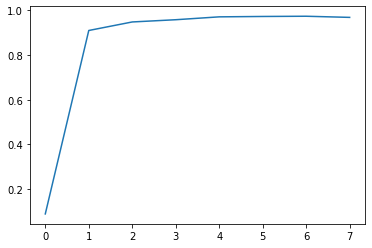

In [58]:
# 1e-3
plt.plot(accuracy_list_psgld)

print(accuracy_list_psgld[-1:])

### optimiser

In [5]:
from jax.experimental.optimizers import adam
# from sgmcmcjax.diffusions import sgld
from sgmcmcjax.util import build_grad_log_post
# from sgmcmcjax.gradient_estimation import build_gradient_estimation_fn

In [11]:
update

<function jax.experimental.optimizers.adam.<locals>.update(i, g, state)>

In [42]:
grad_log_post = build_grad_log_post(loglikelihood, logprior, data)

def pot_fn(p, x, y):
    return jax.tree_util.tree_map(lambda t:-t, grad_log_post(p,x,y))

init_fn, update, get_params = adam(1e-3)

Niters = 5000

N_data = data[0].shape[0]
key = random.PRNGKey(0)

accuracy_list = []
batch_size = int(0.001*N_data)
params = cnn.init(key, jnp.ones([1,28,28,1]))['params']
state = init_fn(params)

@jit
def update_adam(key, i, state):
    key, subkey = random.split(key)
    idx_batch = random.choice(key=subkey, a=jnp.arange(N_data), shape=(batch_size,))
    minibatch_data = tuple([elem[idx_batch] for elem in data])
    mygrad = pot_fn(get_params(state), *minibatch_data)
    state = update(i, mygrad, state)
    return key, state
    
for i in tqdm(range(Niters)):
    key, state = update_adam(key, i, state)
    if i%500==0:
        accuracy_list.append(accuracy_cnn(get_params(state), X_test_s, y_test_s))

  0%|          | 0/5000 [00:00<?, ?it/s]

99.13


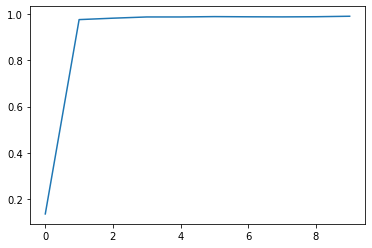

In [45]:
# adam, 1e-3
plt.plot(accuracy_list)

print(accuracy_list[-1]*100)

In [ ]:
# grad_log_post(params, *data)